In [ ]:
import random
import numpy as np
import pandas as pd
import cv2 as cv
import os
import glob
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
from torchsummary import summary
from sklearn.metrics import confusion_matrix

# To guarantee reproducible results 
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2)

## 4.1 GPU status check

In [ ]:
!nvidia-smi

Sun Jun 21 01:33:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 4.2 Download and inspect dataset

In [ ]:
# map My Drive to the colab 
# after this you should see My Drive in on the left-panel
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/Kaggle/aiat-hackathon-1-2020.zip'

Archive:  /content/drive/My Drive/Colab Notebooks/Kaggle/aiat-hackathon-1-2020.zip
  inflating: test_release/test001.png  
  inflating: test_release/test002.jpeg  
  inflating: test_release/test003.png  
  inflating: test_release/test004.jpeg  
  inflating: test_release/test005.jpg  
  inflating: test_release/test006.jpeg  
  inflating: test_release/test007.jpeg  
  inflating: test_release/test008.png  
  inflating: test_release/test009.png  
  inflating: test_release/test010.png  
  inflating: test_release/test011.png  
  inflating: test_release/test012.png  
  inflating: test_release/test013.jpeg  
  inflating: test_release/test014.png  
  inflating: test_release/test015.png  
  inflating: test_release/test016.png  
  inflating: test_release/test017.png  
  inflating: test_release/test018.png  
  inflating: test_release/test019.png  
  inflating: test_release/test020.png  
  inflating: test_release/test021.png  
  inflating: test_release/test022.png  
  inflating: test_release/test02

In [ ]:
os.mkdir('train_equalize/')
os.mkdir('val_equalize/')
os.mkdir('test_equalize/')

In [ ]:
path = ['train/covid/','train/normal/','train/pneumonia/','val/covid/','val/normal/','val/pneumonia/','test_release/']
save_path = ['train_equalize/covid/','train_equalize/normal/','train_equalize/pneumonia/','val_equalize/covid/','val_equalize/normal/','val_equalize/pneumonia/','test_equalize/test/']
j = 2
for i in range(len(path)):
    files = glob.glob(path[i] + "*")
    os.mkdir(save_path[i])
    if i ==6:
        j = 1
    for f1 in files:
        img = cv.imread(f1)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.equalizeHist(img)
        img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        cv.imwrite(save_path[i] + f1.split(sep='/')[j], img)

In [ ]:
### Helper function to display image from dataset ###
def getImageFromDataset(dataset, idx):
  sampleImage, sampleLabel = dataset.__getitem__(idx)
  ### Revert transformation ###
  sampleImage = ((sampleImage.permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]))*255
  sampleImage = sampleImage.astype(np.uint8)
  sampleClassName = dataset.classes[sampleLabel]
  return sampleImage, sampleClassName

In [ ]:
### Dataset Augmentation (https://pytorch.org/docs/stable/torchvision/transforms.html) ###
transformTrain = transforms.Compose([        
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

transformTest =  transforms.Compose([
        transforms.Resize(size=(256,256)),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
### Dataloader for our dataset ###
covidTrainDataset = ImageFolder('train_equalize/', transform=transformTrain)
covidValDataset = ImageFolder('val_equalize/', transform=transformTest)
covidTestDataset = ImageFolder('test_equalize/', transform=transformTest)

print('Total train set images :', len(covidTrainDataset))
print('Total validate set images :', len(covidValDataset))
print('Total test set images :', len(covidTestDataset))

Total train set images : 680
Total validate set images : 85
Total test set images : 85



## 4.3 Dataset visualization

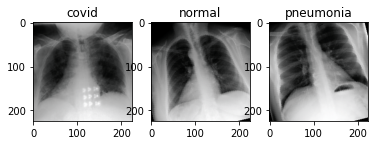

In [ ]:
covidImage, covidClassName = getImageFromDataset(covidTrainDataset, 0)
normalImage, normalClassName = getImageFromDataset(covidTrainDataset, 230)
pneumoniaImage, pneumoniaClassName = getImageFromDataset(covidTrainDataset, 480)

_, figure = plt.subplots(1,3)

figure[0].imshow(covidImage,cmap='gray')
figure[0].title.set_text(covidClassName)

figure[1].imshow(normalImage,cmap='gray')
figure[1].title.set_text(normalClassName)

figure[2].imshow(pneumoniaImage,cmap='gray')
figure[2].title.set_text(pneumoniaClassName)

plt.show()

## 4.4 Define CNN network for pneumonia classification

### Simple max pooling with bn: mean_f1_score:0.6874125874125874

In [ ]:
### Build simple CNN ###
class covidNet(nn.Module):
  def __init__(self):
    super(covidNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
    self.conv2_1 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
    self.conv2_2 = nn.Conv2d(3, 16, kernel_size=1, stride=1)
    self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)                          # [16, 32, 27, 27]
    self.bn1 = nn.BatchNorm2d(16)
    
    self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.conv4_1 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
    self.conv4_2 = nn.Conv2d(16, 32, kernel_size=1, stride=1)
    self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.bn2 = nn.BatchNorm2d(32)
        
    self.conv5 = nn.Conv2d(32, 48, kernel_size=3, stride=1, padding=1)
    self.conv6_1 = nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1)
    self.conv6_2 = nn.Conv2d(32, 48, kernel_size=1, stride=1)
    self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.bn3 = nn.BatchNorm2d(48)
    
    self.conv7 = nn.Conv2d(48, 64, kernel_size=3, stride=1, padding=1)
    self.conv8_1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.conv8_2 = nn.Conv2d(48, 64, kernel_size=1, stride=1)
    self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)                          # [16, 256, 2, 2]
    self.bn4 = nn.BatchNorm2d(64)
    
    self.conv9 = nn.Conv2d(64, 80, kernel_size=3, stride=1, padding=1)
    self.conv10_1 = nn.Conv2d(80, 80, kernel_size=3, stride=1, padding=1)
    self.conv10_2 = nn.Conv2d(64, 80, kernel_size=1, stride=1)
    self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)
    self.bn5 = nn.BatchNorm2d(80)
    
    self.fc1 = nn.Linear(80*6*6, 4096) ### (inputnode=25088, outputnode=4096)
    self.fc2 = nn.Linear(4096, 3)


  def forward(self, input): # 1 x 3 x 512 x 512
    #print(input.shape)
    x_1 = F.relu(self.conv1(input))
    x_2_1 = F.relu(self.conv2_1(x_1))
    x_2_2 = F.relu(self.conv2_2(input))
    x = self.pool1(self.bn1(x_2_1 + x_2_2))
    #print(x.shape)

    x_3 = F.relu(self.conv3(x))
    x_4_1 = F.relu(self.conv4_1(x_3))
    x_4_2 = F.relu(self.conv4_2(x))
    x = self.pool1(self.bn2(x_4_1 + x_4_2))

    x_5 = F.relu(self.conv5(x))
    x_6_1 = F.relu(self.conv6_1(x_5))
    x_6_2 = F.relu(self.conv6_2(x))
    x = self.pool1(self.bn3(x_6_1 + x_6_2))

    x_7 = F.relu(self.conv7(x))
    x_8_1 = F.relu(self.conv8_1(x_7))
    x_8_2 = F.relu(self.conv8_2(x))
    x = self.pool1(self.bn4(x_8_1 + x_8_2))

    x_9 = F.relu(self.conv9(x))
    x_10_1 = F.relu(self.conv10_1(x_9))
    x_10_2 = F.relu(self.conv10_2(x))
    x = self.pool1(self.bn5(x_10_1 + x_10_2))
    #print(x.shape)
    x = x.view(-1, 80*6*6) ### change to (1,25088)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

### VGG19_bn: mean_f1_score:0.7076388888888889

In [ ]:
from torchvision.models import vgg19_bn

def make_net(pretrain, freeze):
    net = vgg19_bn(pretrained=pretrain)
    net.fc = nn.Sequential(
        nn.Linear(2048, 100),
        nn.Linear(100, 3)
    )
    # freeze = only train the "fc" layer
    if freeze:
        # disable gradients for all 
        net.requires_grad_(False)
        # except fc
        net.fc.requires_grad_(True)
    return net

In [ ]:
# verify the network with dummy input
coviNet = make_net(pretrain=True, freeze=False)
coviNet(torch.randn(1, 3, 224, 224))

In [ ]:
coviNet.cuda()

### VGG19_bn with pooling and drop out on top : mean_f1_score:0.6415701415701416

In [ ]:
from torchvision.models import vgg19_bn

def make_net(pretrain, freeze):
    net = vgg19_bn(pretrained=pretrain)
    net.avgpool = nn.Sequential(
             nn.AdaptiveAvgPool2d(output_size=(7,7)),
             nn.AvgPool2d(kernel_size=(3,3),stride=(2,2)),
             nn.Flatten()) 
    net.classifier[0] = nn.Linear(4608, 4096)
    net.classifier[6] = nn.Sequential(
             nn.Linear(4096, 1000),
             nn.ReLU(),
             nn.Dropout(0.5),
             nn.Linear(1000, 3),
             nn.Softmax(dim=1)
             )
    # freeze = only train the "fc" layer
    if freeze:
        # disable gradients for all 
        net.requires_grad_(False)
        # except fc
        net.fc.requires_grad_(True)
    return net

In [ ]:
# verify the network with dummy input
coviNet = make_net(pretrain=True, freeze=False)
coviNet(torch.randn(1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/checkpoints/vgg19_bn-c79401a0.pth


tensor([[0.3347, 0.3383, 0.3270]], grad_fn=<SoftmaxBackward>)

In [ ]:
coviNet.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
summary(coviNet, input_size=(3, 224, 224), batch_size=32, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
       BatchNorm2d-2         [32, 64, 224, 224]             128
              ReLU-3         [32, 64, 224, 224]               0
            Conv2d-4         [32, 64, 224, 224]          36,928
       BatchNorm2d-5         [32, 64, 224, 224]             128
              ReLU-6         [32, 64, 224, 224]               0
         MaxPool2d-7         [32, 64, 112, 112]               0
            Conv2d-8        [32, 128, 112, 112]          73,856
       BatchNorm2d-9        [32, 128, 112, 112]             256
             ReLU-10        [32, 128, 112, 112]               0
           Conv2d-11        [32, 128, 112, 112]         147,584
      BatchNorm2d-12        [32, 128, 112, 112]             256
             ReLU-13        [32, 128, 112, 112]               0
        MaxPool2d-14          [32, 128,

### Resnet152: mean_f1_score:0.7195121951219512

In [ ]:
from torchvision.models import resnet152

def make_net(pretrain, freeze):
    net = resnet152(pretrained=pretrain)

    net.fc = nn.Sequential(
             nn.Linear(2048, 256), 
             nn.ReLU(), 
             nn.Dropout(0.4,),
             nn.Linear(256, 3)
             )
    # freeze = only train the "fc" layer
    if freeze:
        # disable gradients for all 
        net.requires_grad_(False)
        # except fc
        net.fc.requires_grad_(True)
    return net

In [ ]:
# verify the network with dummy input
coviNet = make_net(pretrain=True, freeze=False)
coviNet(torch.randn(1, 3, 224, 224))

tensor([[ 0.0577,  0.0480, -0.0211]], grad_fn=<AddmmBackward>)

In [ ]:
coviNet.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
summary(coviNet, input_size=(3, 224, 224), batch_size=1, device='cuda')

## 4.5 Construct the model, optimizer and loss function



In [ ]:
coviNet = covidNet()

In [ ]:
# Move to gpu
coviNet = coviNet.to('cuda')
# Distribute across 2 gpus
coviNet = nn.DataParallel(coviNet)

### 4.5.1 Network Debugging

In [ ]:
coviNet.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
### TODO : Add loss function and Adam optimizer ##
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(coviNet.parameters(), lr=8e-6, betas=(0.9, 0.999), eps=1e-08)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

covidTrainDatasetLoader = DataLoader(covidTrainDataset, batch_size=2, shuffle=True, num_workers=8, pin_memory=True)
covidValDatasetLoader = DataLoader(covidValDataset, batch_size=2, shuffle=False, num_workers=8, pin_memory=True)

## 4.5 Train the model

In [ ]:
### Train and test helper function ###
def testModel(testDatasetLoader, net):
  net.eval()
  correctImages = 0
  totalImages = 0
  allLabels = []
  allPredicted = []
  testingProgressbar = tqdm(enumerate(testDatasetLoader), total=len(testDatasetLoader), ncols='100%')
  with torch.no_grad():
    for batchIdx, batchData in testingProgressbar:
      images, labels = batchData
      
      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testingProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )
    
      allLabels.append(labels)
      allPredicted.append(predicted)
  allLabels = torch.cat(allLabels).cpu().numpy()
  allPredicted = torch.cat(allPredicted).cpu().numpy()
  return correctImages, totalImages, allLabels, allPredicted

def trainAndTestModel(trainDatasetLoader, testDatasetLoader, net, optimizer,scheduler, criterion, trainEpoch):
  
  bestAccuracy = 0
  correctImages = 0
  totalImages = 0
  history = []
  for currentEpoch in tqdm(range(trainEpoch), desc='Overall Training Progress:', ncols='100%'):
    trainingLoss = 0.0
    net.train()
    print('Epoch',str(currentEpoch+1),'/',str(trainEpoch))
    trainingProgressbar = tqdm(enumerate(trainDatasetLoader), total=len(trainDatasetLoader), ncols='100%')
    for batchIdx, batchData in trainingProgressbar:
      images, labels = batchData
      images, labels = images.cuda(), labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(images)
      loss = criterion(outputs, labels)
    
      _, predicted = torch.max(outputs, 1)
      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)
    
      loss.backward()
      optimizer.step()
      

      trainingLoss += loss.item()
      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )
    scheduler.step(trainingLoss)
    correctImages, totalImages, allLabels, allPredicted = testModel(testDatasetLoader, net)
    testAccuracy = round((correctImages/totalImages)*100,2)

    print('='*10)
    
    if testAccuracy > bestAccuracy:
      bestAccuracy = testAccuracy
      bestPredicted = allPredicted
      bestNet = net
    history.append([accumulateAccuracy,testAccuracy])
  return bestAccuracy, bestPredicted, allLabels, bestNet, history

In [ ]:
### TODO : Train the model by using trainAndTestModel function ###
bestAccuracy, bestPredicted, allLabels, bestNet, history = trainAndTestModel(covidTrainDatasetLoader, covidValDatasetLoader, 
                                                                    coviNet, 
                                                                    optimizer, scheduler, criterion, 
                                                                    trainEpoch=30)

Epoch 1 / 30



Epoch 2 / 30



Epoch 3 / 30



Epoch 4 / 30



Epoch 5 / 30



Epoch 6 / 30



Epoch 7 / 30



Epoch 8 / 30



Epoch 9 / 30



Epoch 10 / 30



Epoch 11 / 30



Epoch 12 / 30



Epoch 13 / 30



Epoch 14 / 30



Epoch 15 / 30



Epoch 16 / 30



Epoch 17 / 30



Epoch 18 / 30



Epoch 19 / 30



Epoch 20 / 30



Epoch 21 / 30



Epoch 22 / 30



Epoch 23 / 30



Epoch 24 / 30



Epoch 25 / 30



Epoch 26 / 30



Epoch 27 / 30



Epoch 28 / 30



Epoch 29 / 30



Epoch 30 / 30


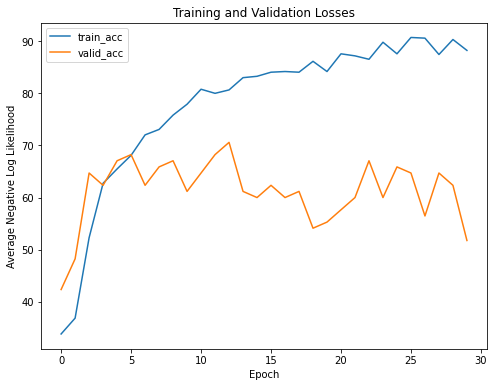

In [ ]:
history = pd.DataFrame(history, columns=['train_acc', 'valid_acc'])
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(history[c], label=c)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Average Negative Log Likelihood')
    plt.title('Training and Validation Losses')

In [ ]:
# Save model
torch.save(bestNet.state_dict(), 'coviNet.checkpoint.pth')

## 4.6 Find the confusion matrix and calculate TP, TN, FP, and FN

In [ ]:
### Confusion matrix plot helper function from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix ###
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

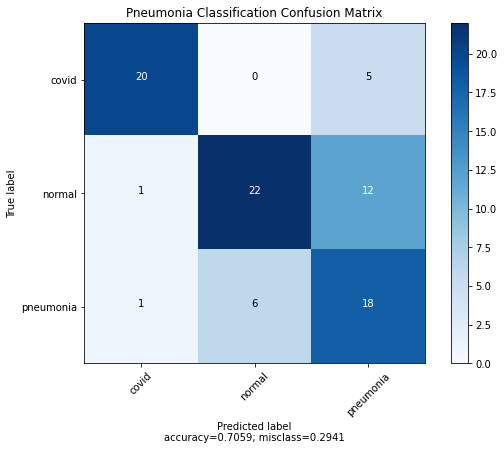

In [ ]:
confusionMatrix = confusion_matrix(allLabels, bestPredicted)
plot_confusion_matrix(cm           = confusionMatrix, 
                      normalize    = False,
                      target_names = covidTrainDataset.classes,
                      title        = "Pneumonia Classification Confusion Matrix")

In [ ]:
confusionMatrix

array([[20,  0,  5],
       [ 1, 22, 12],
       [ 1,  6, 18]])

In [ ]:
precision_covid = confusionMatrix[0][0]/(confusionMatrix[0][0]+confusionMatrix[1][0])
recall_covid = confusionMatrix[0][0]/(confusionMatrix[0][0]+confusionMatrix[0][1])
f1_score_covid = 2 * (precision_covid * recall_covid) / (precision_covid + recall_covid)

precision_pneu = confusionMatrix[2][2]/(confusionMatrix[2][2]+confusionMatrix[1][2])
recall_pneu = confusionMatrix[2][2]/(confusionMatrix[2][2]+confusionMatrix[2][1])
f1_score_pneu = 2 * (precision_pneu * recall_pneu) / (precision_pneu + recall_pneu)

mean_f1_score = (f1_score_covid+f1_score_pneu)/2
print('f1_score_covid:{}'.format(f1_score_covid))
print('f1_score_pneu:{}'.format(f1_score_pneu))
print('mean_f1_score:{}'.format(mean_f1_score))

f1_score_covid:0.975609756097561
f1_score_pneu:0.6666666666666665
mean_f1_score:0.8211382113821137


In [ ]:
def showRandomSamples(labels, predicted, testDataset, sampleNum=5):
  equals = labels == predicted
  correctIdx = np.where(equals == 1)[0].tolist()
  incorrectIdx = np.where(equals == 0)[0].tolist()

  randomCorrectIdx = random.sample(correctIdx, sampleNum)
  randomIncorrectIdx  = random.sample(incorrectIdx, sampleNum)

  _, figure = plt.subplots(2,sampleNum,figsize=(30,10))

  ### Plot Correct ###
  for imageIdx in range(len(randomCorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomCorrectIdx[imageIdx])
    figure[0,imageIdx].imshow(image,cmap='gray')
    figure[0,imageIdx].title.set_text('[CORRECT] '+className)

  for imageIdx in range(len(randomIncorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomIncorrectIdx[imageIdx])
    figure[1,imageIdx].imshow(image,cmap='gray')
    predictedClassName = testDataset.classes[predicted[randomIncorrectIdx[imageIdx]]]
    figure[1,imageIdx].title.set_text('Actual:'+className+' Predicted:' + predictedClassName)

  plt.show()

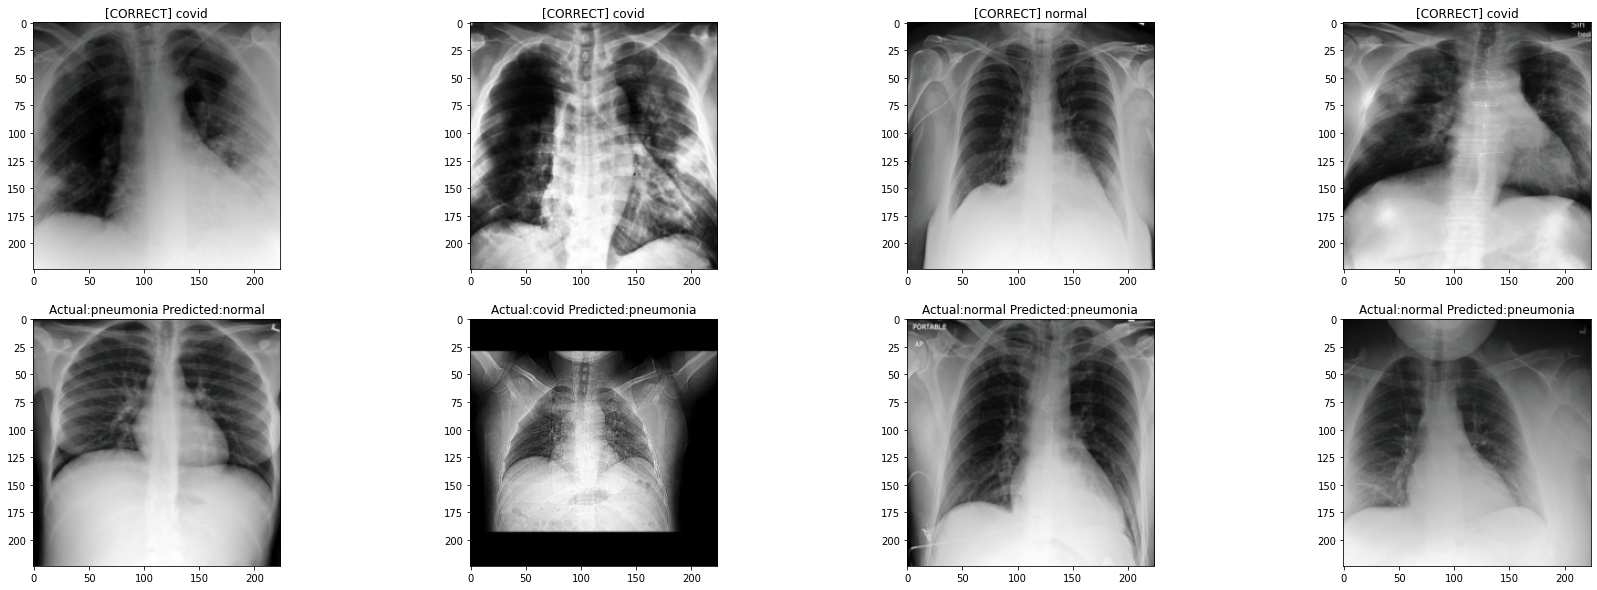

In [ ]:
showRandomSamples(allLabels,bestPredicted,covidValDataset,sampleNum=4)

# Prediction Test data

In [ ]:
files = glob.glob("test_equalize/test/*")
test_ids = []
for f1 in files:
    test_ids.append(f1.split(sep='/')[2].split(sep='.')[0])

In [ ]:
covidTestDatasetLoader = DataLoader(covidTestDataset, batch_size=2, shuffle=False, num_workers=8, pin_memory=True)

In [ ]:
correctImages, totalImages, allLabels, allPredicted = testModel(covidTestDatasetLoader, bestNet)

In [ ]:
allPredicted

array([2, 0, 1, 0, 0, 0, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 2, 1, 2, 0, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 2, 0,
       2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 0, 2, 2, 1, 1, 0, 2, 1, 1, 2, 2, 2,
       0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 1, 2, 1, 2, 1, 1, 2, 2])

In [ ]:
pred_df = pd.DataFrame({'Id':test_ids,'Predicted':allPredicted},index=None)
pred_df.sort_values('Id',inplace=True)
pred_df

,Id,Predicted
15,test001,2
12,test002,2
21,test003,2
19,test004,2
31,test005,2
...,...,...
52,test081,0
59,test082,0
73,test083,2
25,test084,0


In [ ]:
pred_df.Predicted.value_counts()

2    48
0    20
1    17
Name: Predicted, dtype: int64

In [ ]:
pred_df.to_csv('submission_5.csv',index=False)